# Week 2: Predicting time series

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Sequences_Time_Series_and_Prediction/Week2/Labs/C4W2_Assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

Let's get started!

_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete some of the cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and also refrain from adding any new cells. **Once you have passed this assignment** and want to experiment with any of the locked cells, you may follow the instructions at the bottom of this notebook._

In [1]:
import numpy as np
import tensorflow as tf
from keras import Sequential, Input, layers, optimizers, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

2024-06-13 20:32:29.194360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generating the data


The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    sns.set_style("whitegrid")
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")

def trend(time, slope=0):
    
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    
    season_time = ((time + phase) % period) / period
    
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    
    return rnd.randn(len(time)) * noise_level

You will be generating time series data that greatly resembles the one from last week but with some differences.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the previous week.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html). 

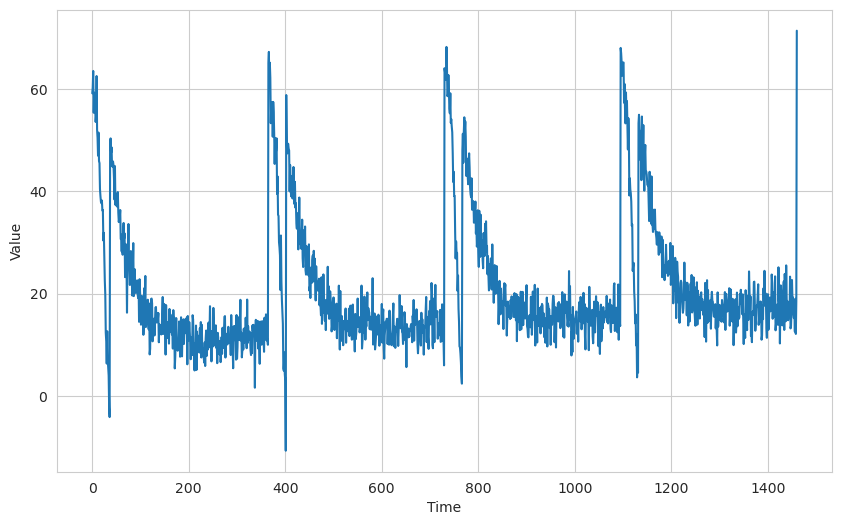

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Splitting the data

Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Processing the data

As you saw on the lectures you can feed the data for training by creating a dataset with the appropiate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. To do so complete the `windowed_dataset` function below.

Notice that this function receives a `series`, `window_size`, `batch_size` and `shuffle_buffer` and the last three of these default to the "global" values defined earlier.

Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) about `TF Datasets` if you need any help.

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ### START CODE HERE
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    ### END CODE HERE
    
    return dataset

To test your function you will be using a `window_size` of 1 which means that you will use each value to predict the next one. This for 5 elements since a `batch_size` of 5 is used and no shuffle since `shuffle_buffer` is set to 1.

Given this, the batch of features should be identical to the first 5 elements of the `series_train` and the batch of labels should be equal to elements 2 through 6 of the `series_train`.

In [6]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


2024-06-13 20:32:31.488982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1745 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True
```

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Hint:
- You will only need `Dense` layers.
- Do not include `Lambda` layers. These are not required and are incompatible with the `HDF5` format which will be used to save your model for grading.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.

In [7]:
def create_model(window_size=G.WINDOW_SIZE):
    ### START CODE HERE
    model = Sequential([Input(shape=(window_size,)),
                        layers.Dense(10, activation="relu"),
                        layers.Dense(10, activation="relu"),
                        layers.Dense(1)]) 

    model.compile(loss="mse",
                  optimizer=optimizers.SGD(learning_rate=4e-6, momentum=0.9))
    ### END CODE HERE

    return model

In [8]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train it
model.fit(dataset, epochs=100)

Epoch 1/100


I0000 00:00:1718332351.984039  493050 service.cc:145] XLA service 0x7f9600006aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718332351.984063  493050 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-13 20:32:31.994945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 20:32:32.037333: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


      1/Unknown 1s 826ms/step - loss: 1584.4059

I0000 00:00:1718332352.467089  493050 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 635.3766
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 59.6232
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 44.8553
Epoch 4/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 15.9669

2024-06-13 20:32:32.866158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:32.866187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:32.866196: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:32.866206: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
/home/luis-mendoza/anaconda3/envs/TDPC_env/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dat

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 55.8925
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 41.0373
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 38.8283
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 47.2665


2024-06-13 20:32:33.071718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.071744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:33.071751: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:33.071759: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:33.139372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.139400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 47.6814
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 38.1538
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 52.4437
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 46.7745
Epoch 12/100


2024-06-13 20:32:33.335761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.335786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:33.335797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:33.335807: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:33.400969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.400993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 38.9278
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 53.7876
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 39.6945
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 46.4533
Epoch 16/100


2024-06-13 20:32:33.596977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.597001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:33.597009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:33.597016: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:33.663397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.663422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 46.2230
Epoch 17/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 31.8096
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 48.1625
Epoch 19/100


2024-06-13 20:32:33.858689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.858712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:33.858720: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:33.858727: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:33.967938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:33.967962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 46.6039
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 30.9762
Epoch 21/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 35.4509
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 37.0876
Epoch 23/100


2024-06-13 20:32:34.101429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.101452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:34.101459: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:34.101467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:34.166528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.166549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 34.0698
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 40.4243
Epoch 25/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 39.3440
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 42.2062


2024-06-13 20:32:34.363335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.363359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:34.363367: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:34.363375: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:34.432817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.432849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

Epoch 27/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 33.3528
Epoch 28/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 32.6397
Epoch 29/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 34.6918
Epoch 30/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 15.4177

2024-06-13 20:32:34.635950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.635973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:34.635981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:34.635989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:34.703213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.703237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 30.7935
Epoch 31/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 37.6200
Epoch 32/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 35.4457
Epoch 33/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 30.3155
Epoch 34/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 37.7467
Epoch 35/100


2024-06-13 20:32:34.907344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.907368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:34.907376: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:34.907383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:34.974216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:34.974240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 32.7444
Epoch 36/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 29.1846
Epoch 37/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 33.9677
Epoch 38/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 23.7435

2024-06-13 20:32:35.174440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.174463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:35.174471: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:35.174478: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:35.246332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.246354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 22.3602
Epoch 39/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 30.7360
Epoch 40/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 32.2920
Epoch 41/100


2024-06-13 20:32:35.378508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.378533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:35.378543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:35.378553: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:35.488399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.488423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 23.9989
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 21.7003
Epoch 43/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 36.4914
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 31.3592
Epoch 45/100


2024-06-13 20:32:35.621591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.621614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:35.621622: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:35.621630: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:35.687107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.687137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 26.5372
Epoch 46/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 26.3383
Epoch 47/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 21.4767
Epoch 48/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 12.3688

2024-06-13 20:32:35.888939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.888963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:35.888971: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:35.888979: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:35.956658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:35.956683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 32.1412
Epoch 49/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 33.6567
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 27.4193
Epoch 51/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 29.7783
Epoch 52/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 106.6918

2024-06-13 20:32:36.156674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.156698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:36.156705: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:36.156713: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:36.225022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.225046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 29.2101
Epoch 53/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 33.1357
Epoch 54/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 25.6359
Epoch 55/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 24.0462
Epoch 56/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 12.6363

2024-06-13 20:32:36.422668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.422693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:36.422702: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:36.422710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:36.490632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.490656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 29.3211
Epoch 57/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 25.0477
Epoch 58/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 26.7563
Epoch 59/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 23.2031
Epoch 60/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 13.9537

2024-06-13 20:32:36.690545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.690568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:36.690575: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:36.690583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:36.756776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.756799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 22.8233
Epoch 61/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 31.9059
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 21.1907
Epoch 63/100


2024-06-13 20:32:36.895715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.895740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:36.895748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:36.895756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:36.961681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:36.961705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 28.3897
Epoch 64/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 23.1706
Epoch 65/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 25.0887
Epoch 66/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 12.9394

2024-06-13 20:32:37.136208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.136232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:37.136240: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:37.136247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:37.202743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.202767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 22.9771
Epoch 67/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 22.5723
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 24.7547
Epoch 69/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 35.0768
Epoch 70/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 9.8483

2024-06-13 20:32:37.403171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.403195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:37.403202: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:37.403210: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:37.471155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.471179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 23.7963
Epoch 71/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 29.6650
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 26.0238
Epoch 73/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 23.0148


2024-06-13 20:32:37.606949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.606972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:37.606980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:37.606989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:37.673940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.673966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

Epoch 74/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 24.5627
Epoch 75/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 28.0120
Epoch 76/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 24.5998
Epoch 77/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 10.7815

2024-06-13 20:32:37.871507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.871530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:37.871538: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:37.871545: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:37.938496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:37.938519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 25.5977
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 23.5866
Epoch 79/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 26.3597
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 28.3783
Epoch 81/100


2024-06-13 20:32:38.073704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.073730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:38.073739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:38.073748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:38.140616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.140648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 30.0119
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 23.4437
Epoch 83/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.7664
Epoch 84/100


2024-06-13 20:32:38.338847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.338869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:38.338878: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:38.338885: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:38.407384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.407409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 30.3247
Epoch 85/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 24.4453
Epoch 86/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 20.3155
Epoch 87/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 31.4543
Epoch 88/100


2024-06-13 20:32:38.616585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.616607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:38.616615: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:38.616623: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:38.682185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.682210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 22.4602
Epoch 89/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 22.9053
Epoch 90/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 27.7201
Epoch 91/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 25.3120
Epoch 92/100


2024-06-13 20:32:38.880426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.880451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:38.880459: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:38.880468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:38.946426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:38.946450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 29.0192
Epoch 93/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 22.4297
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 28.9605
Epoch 95/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 99.6396

2024-06-13 20:32:39.143716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:39.143740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:39.143748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:39.143756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:39.212349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:39.212370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 29.7199
Epoch 96/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 37.3062
Epoch 97/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 26.8614
Epoch 98/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 9.9134

2024-06-13 20:32:39.345648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:39.345671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:39.345679: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:39.345689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:39.413368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:39.413391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 20.4096
Epoch 99/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 18.2704
Epoch 100/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 18.2730


2024-06-13 20:32:39.546618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:39.546640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-13 20:32:39.546648: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10482314915312963533
2024-06-13 20:32:39.546655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12081537584217662842
2024-06-13 20:32:39.615954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-13 20:32:39.615978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: 

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [9]:
def compute_metrics(true_series, forecast):
    mse = metrics.mean_squared_error(true_series, forecast).numpy()
    mae = metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

For this, run the cell below which uses the `generate_forecast` function to compute the forecast. This function generates the next value given a set of the previous `window_size` points for every point in the validation set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

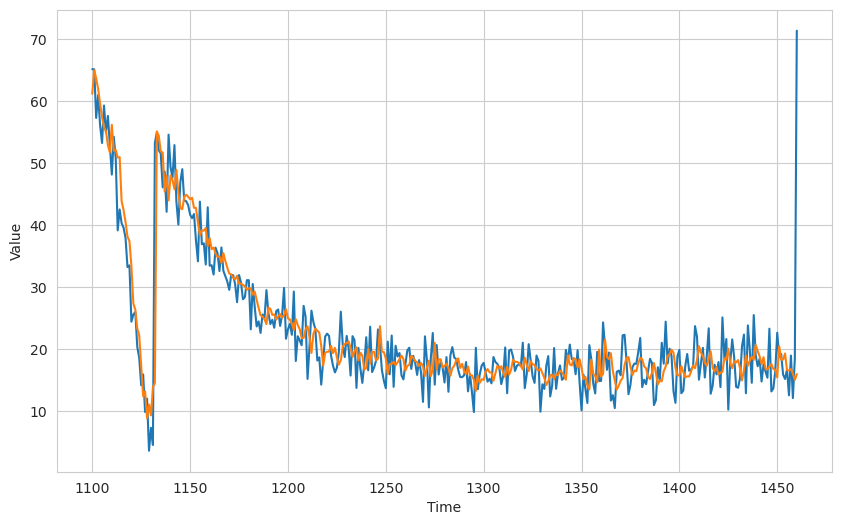

In [10]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    
    return results

# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="./images/forecast.png" width="500"/>
</div>

In [11]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 26.49, mae: 3.24 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a HDF5 file file which will be used for grading and after doing so, submit your assigment for grading.


- Make sure you didn't use `Lambda` layers in your model since these are incompatible with the `HDF5` format which will be used to save your model for grading.


- This environment includes a dummy `my_model.h5` file which is just a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [12]:
# Save your model in HDF5 format
# model.save('./my_model.h5')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**